In [1]:
import os
import numpy as np

import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

# Continue with regular imports
import matplotlib.pyplot as plt

# Try to get torchinfo for summary of model, install it if it doesn't work
try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary


In [2]:
from utils.accuracy import accuracy
from utils.train_test import *

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Datatransforms

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets

In [5]:
DATA_DIR = 'brain_dataset'
SPLIT_RATIO = 0.8

# Import dataset
dataset = datasets.ImageFolder(root=DATA_DIR)

# Split dataset
train_size = int(SPLIT_RATIO * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#Assign transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

classes = dataset.classes
len(train_dataset), len(test_dataset), classes

(201, 51, ['no', 'yes'])

# Dataloaders

In [6]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1d288aa3e90>,
 <torch.utils.data.dataloader.DataLoader at 0x1d2e4dbad90>)

# Examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

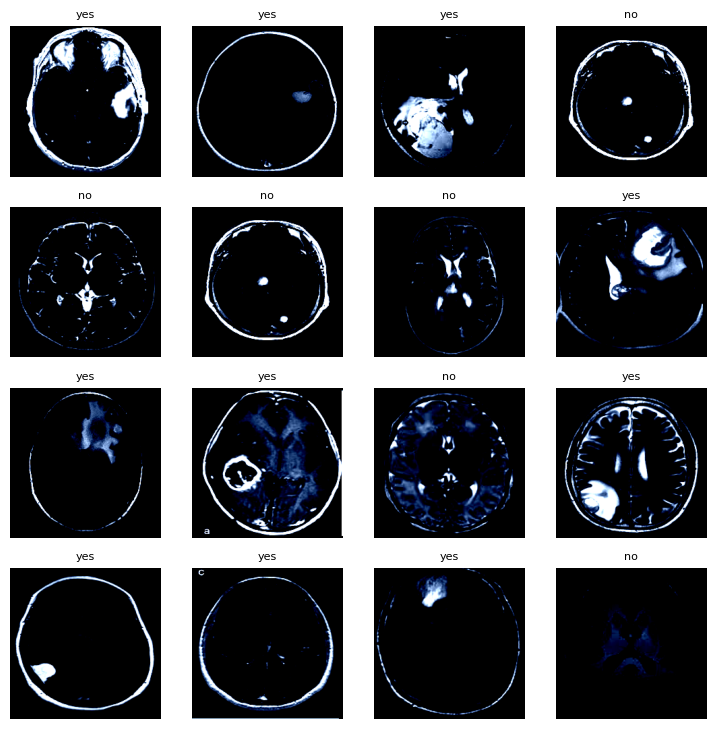

In [7]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
  image, true_label = train_dataset[random_idx]

  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0), cmap="gray")

  plt.title(f"{classes[true_label]}", fontsize=8)
  plt.axis(False)

# Model

In [8]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)
model.to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [9]:
summary(model=model, input_size = (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

# Freezing

In [10]:
for param in model.features.parameters():
  param.requires_grad = False

#summary(model=model, input_size = (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

# Head Update

In [11]:
model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True), nn.Linear(1280, 1))

In [12]:
summary(model=model, input_size = (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# Loss function and optimizer

In [13]:
loss_fn = nn.BCEWithLogitsLoss()

#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train

In [14]:
from tqdm.auto import tqdm
import time

train_losses = []
test_losses = []
test_accuracies = []

In [15]:
EPOCHS = 30

program_starts = time.time()
for epoch in tqdm(range(EPOCHS)):
  train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
  test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)

  train_losses.append(train_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  print(f"Epoch: {epoch+1} | Training Loss: {train_loss} | Test Loss: {test_loss} | Test acc: {test_accuracy}%")


program_ends = time.time()

print(f"Elapsed: {program_ends-program_starts}s")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 0.6504677534103394 | Test Loss: 0.6358796954154968 | Test acc: 74.50980392156863%
Epoch: 2 | Training Loss: 0.5601427555084229 | Test Loss: 0.6018029451370239 | Test acc: 80.3921568627451%
Epoch: 3 | Training Loss: 0.536316454410553 | Test Loss: 0.5711339116096497 | Test acc: 80.3921568627451%
Epoch: 4 | Training Loss: 0.5031381249427795 | Test Loss: 0.5464786887168884 | Test acc: 78.43137254901961%
Epoch: 5 | Training Loss: 0.4580872356891632 | Test Loss: 0.5064294934272766 | Test acc: 82.3529411764706%
Epoch: 6 | Training Loss: 0.4362376034259796 | Test Loss: 0.4759467840194702 | Test acc: 82.3529411764706%
Epoch: 7 | Training Loss: 0.406864732503891 | Test Loss: 0.4533557593822479 | Test acc: 84.31372549019608%
Epoch: 8 | Training Loss: 0.396269828081131 | Test Loss: 0.43754053115844727 | Test acc: 86.27450980392157%
Epoch: 9 | Training Loss: 0.36996376514434814 | Test Loss: 0.4165177345275879 | Test acc: 84.31372549019608%
Epoch: 10 | Training Loss: 0.3709

# Plot

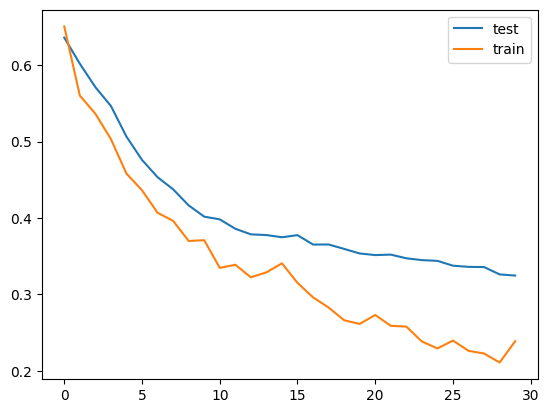

In [16]:
plt.plot(test_losses, label="test")
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

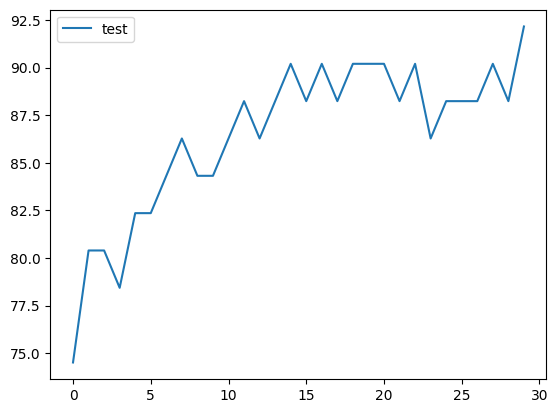

In [17]:
#plt.plot(train_accuracies, label="train")
plt.plot(test_accuracies, label="test")
plt.legend()
plt.show()

## Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

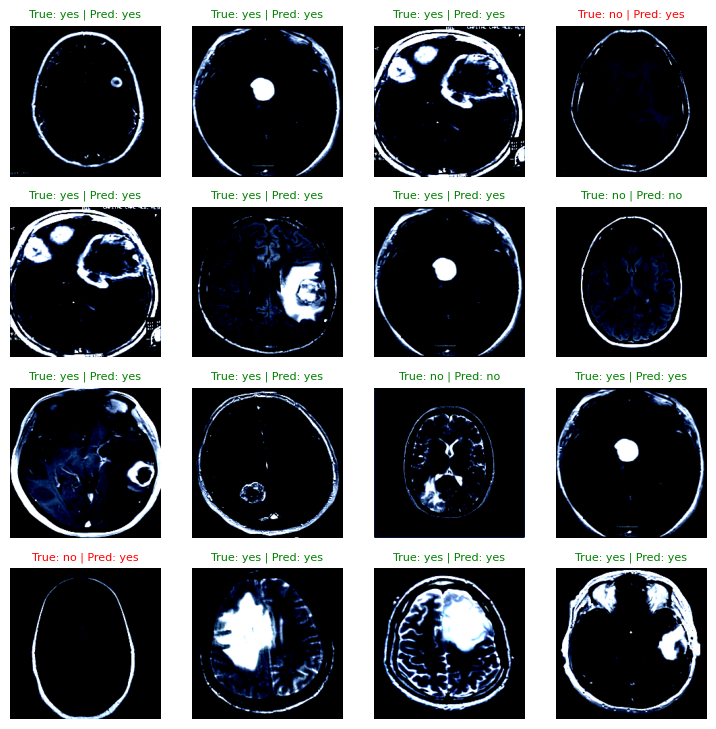

In [18]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
  image, true_label = test_dataset[random_idx]

  predicted_label = model(image.unsqueeze(dim=0).to(device))
  predicted_label = (predicted_label > 0).int().squeeze()

  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0), cmap="gray")
  if true_label == predicted_label:
    color = "g"
  else:
    color = "r"
  plt.title(f"True: {classes[true_label]} | Pred: {classes[predicted_label]}", fontsize=8, c=color)
  plt.axis(False)

## Confusion matrix

  0%|          | 0/51 [00:00<?, ?it/s]

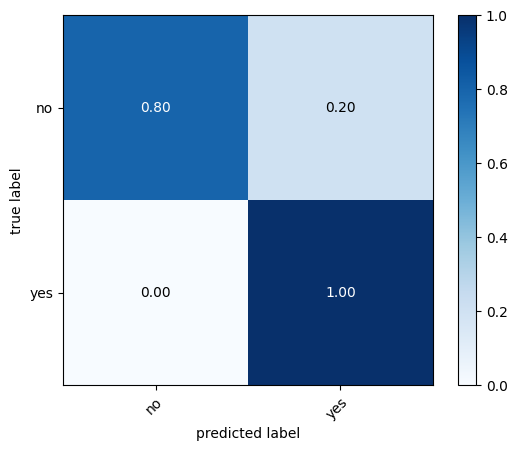

In [19]:
try:
  from torchmetrics import ConfusionMatrix
except:
  !pip install torchmetrics
  from torchmetrics import ConfusionMatrix

try:
  from mlxtend.plotting import plot_confusion_matrix
except:
  !pip install mlxtend
  from mlxtend.plotting import plot_confusion_matrix

y_preds = []
true_labels = []

for i in tqdm(range(len(test_dataset))):
  image, true_label = test_dataset[i]
  predicted_label = model(image.unsqueeze(dim=0).to(device))
  predicted_label = (predicted_label > 0).int().squeeze()
  y_preds.append(predicted_label)
  true_labels.append(true_label)

y_preds = torch.tensor(y_preds).squeeze()
true_labels = torch.tensor(true_labels).squeeze()

confmat = ConfusionMatrix(task="multiclass", num_classes=2)
matrix = np.array(confmat(y_preds, true_labels))

fig, ax = plot_confusion_matrix(conf_mat=matrix, colorbar=True, show_absolute=False, show_normed=True, class_names=classes)
plt.show()

In [20]:
print([loss.item() for loss in train_losses])
print([loss.item() for loss in test_losses])
print(test_accuracies)
print([[int(i) for i in row]for row in matrix])

[0.6504677534103394, 0.5601427555084229, 0.536316454410553, 0.5031381249427795, 0.4580872356891632, 0.4362376034259796, 0.406864732503891, 0.396269828081131, 0.36996376514434814, 0.37096306681632996, 0.3347742259502411, 0.33882027864456177, 0.3224717974662781, 0.32889360189437866, 0.3407292068004608, 0.3151567876338959, 0.29619884490966797, 0.2829494774341583, 0.2662372887134552, 0.26146554946899414, 0.27318325638771057, 0.2589998245239258, 0.2579663395881653, 0.23848141729831696, 0.22939015924930573, 0.23969542980194092, 0.22627031803131104, 0.22275391221046448, 0.21104660630226135, 0.23884348571300507]
[0.6358796954154968, 0.6018029451370239, 0.5711339116096497, 0.5464786887168884, 0.5064294934272766, 0.4759467840194702, 0.4533557593822479, 0.43754053115844727, 0.4165177345275879, 0.40176624059677124, 0.3982168734073639, 0.3859099745750427, 0.3786078095436096, 0.37767550349235535, 0.37482544779777527, 0.3775581121444702, 0.3652803599834442, 0.3653632402420044, 0.3595609962940216, 0.3